Напишите классификацию заболеваний по базе симптомов, используя любые подходы, связанные с обработкой текстов.

Добейтесь максимальной точности распознавания.

Используйте xLen = 50.

# Импорт библиотек


In [ ]:
from google.colab import files, drive
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline
 
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
 
from sklearn.model_selection import train_test_split
 
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
now = time.time()

drive.mount('/content/drive')
!rm '/content/illness'
!unzip -q '/content/drive/MyDrive/Lessons/lesson5/drive-download-20210817T100428Z-001.zip' -d '/content/illness'

print(f"Время обработки: {round(time.time() - 2, 2)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/illness': No such file or directory
Время обработки: 1633173013.0


In [ ]:
def readText(fileName):
  file = open(fileName, 'r')
  text = file.read()
  text = text.split('\n')
  text_one, text_two = train_test_split(text, test_size=0.2, shuffle=True)
  
  return [" ".join(text_one), " ".join(text_two)]

In [ ]:
def getSet(wordIndex, xLen, step):
  sample = []
  wordLen = len(wordIndex)
  index = 0

  while (index + xLen <= wordLen):
    sample.append(wordIndex[index:index + xLen])
    index += step
  
  return sample

In [ ]:
def getBigSet(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSet(wI, xLen, step))

  xSamples = []
  ySamples = []

  
  for ii in range(nClasses):

    yy = utils.to_categorical(ii, nClasses)
    for elem in classesXSamples[ii]:

      ySamples.append(yy)
      xSamples.append(elem)


  return (np.array(xSamples), np.array(ySamples))

In [ ]:
xLen, step = 50, 5

In [ ]:
def multiTest(model, xTest, yTest, name, className):
  print("НЕЙРОНКА: ", name)
  print('-'*20)
  
  totalSumRec = 0

  nClasses = len(className)

  currPred = model.predict(xTest)
  currOut = np.argmax(currPred, axis=1)

  trueOut = np.argmax(yTest, axis=1)

  val = 0

  for ii in range(len(currOut)):
    if currOut[ii] == trueOut[ii]:
      val += 1

  return val/len(yTest)

In [ ]:
def showPicture(history):

  plt.figure(figsize = (14, 7))
  plt.plot(history.history['loss'], 
          label='Значение ошибки на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Значение ошибки на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.show()

  plt.figure(figsize = (14, 7))
  plt.plot(history.history['accuracy'], 
          label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
          label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.show()

In [ ]:
def create_model(xLen=50):
  model = Sequential()
  model.add(Dense(100, activation="relu", input_shape=(xLen,)))
  model.add(Dense(100, activation="relu"))
  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  model.summary()

  return model

In [ ]:
def createModel(maxWordsCount=20000, xLen=50, level=1):
  model = Sequential()

  model.add(Embedding(maxWordsCount, 5, input_length=xLen))
  model.add(SpatialDropout1D(0.2))
  model.add(BatchNormalization())

  if level not in [1, 2, 3, 4]:
    level = 1

  if level == 1:
    model.add(SimpleRNN(4))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))

  if level == 2:
    model.add(LSTM(4))

  if level == 3: 
    model.add(Conv1D(20, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())

  if level == 4:
    model.add(LSTM(4, return_sequences=1))
    model.add(Dense(100, activation='relu'))
    model.add(Conv1D(20, 5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())


  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

# Подготовка данных

In [ ]:
classes = list()
for name in os.listdir("illness/"):
  classes.append(name.split('.')[0])

In [ ]:
xTrain, yTotal = [], []
xTest = list()

for name in os.listdir("illness/"):
  yTotal.append(name.split('.')[0])
  text = readText(f"illness/{name}")
  xTrain.append(text[0])
  xTest.append(text[1])


In [ ]:
print(xTrain[4])

приступы слюнотечения болезненность при пальпации в эпигастральной области,  Боли в эпигастрии, связанные с приемом пищи (до еды или после),  боль или чувство дискомфорта в области желудка,  - распирание в облсти эпигастрия ощущение тяжести, слабость слабость, - стул нормальный или склонность к запору отрыжка воздухом отрыжка. изжога,  напряжение мышц живота; склонность к запорам,  раздражительность,  ухудшение аппетита,  рвота с примесью желчи; Иррадиация болей — в подреберье, околопупочную область боли в подложечной области, горечь во рту; повышенное газообразование; - отмечается слюнотечение общая слабость. боль в эпигастральной области, - головные боли, слабость рвота и изжога.  болезненность при пальпации в эпигастральной области чувство полноты и распирания в эпигастральной области Отрыжка, отсутствие аппетита тошнота,  отрыжка,  обильное слюнотечение, повышенная утомляемость,  головокружение; рвота, рвота. тошнота,  «горькая» отрыжка, непрекращающаяся икота;  боль под ложечкой р

In [ ]:
print(type(xTrain))

<class 'list'>


Константы

In [ ]:
xLen, step = 50, 5
maxWordsCount = 1000
epochs = 50

In [ ]:
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff',
                      lower=True,
                      char_level=False,
                      oov_token="noName",
                      split=' ')

tokenizer.fit_on_texts(xTrain)
train_index = tokenizer.texts_to_sequences(xTrain)
test_index = tokenizer.texts_to_sequences(xTest)

xTrain, yTrain = getBigSet(train_index, xLen, step)
xTest, yTest = getBigSet(test_index, xLen, step)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 5)             100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 5)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 5)             20        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 4)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               500       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

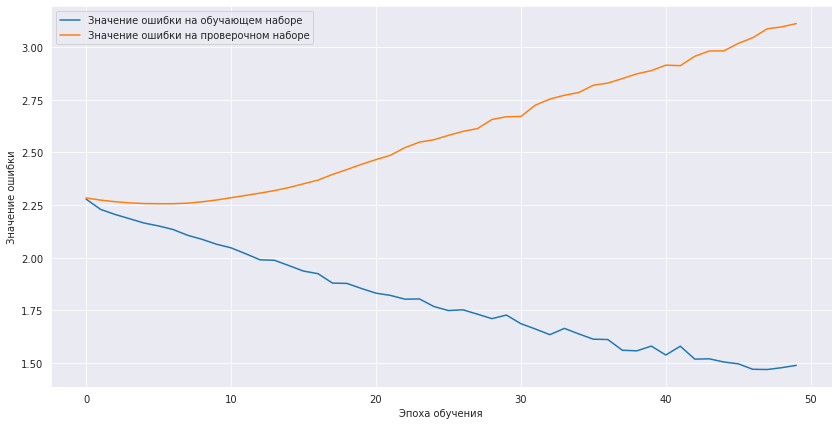

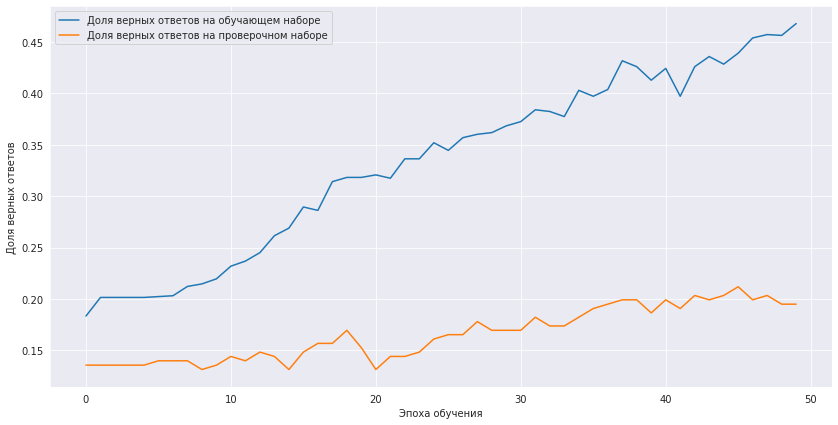

НЕЙРОНКА:  test
--------------------
Процент точности модели: 0.19%


In [ ]:
model = createModel(level=1)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)}%")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 5)             100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 5)             20        
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50        
Total params: 100,230
Trainable params: 100,220
Non-trainable params: 10
_________________________________________________________________
<IPython.core.display.Image object>
Epoch 1/50
19/19 [==============================] - 2s 39ms/step - loss: 2.29

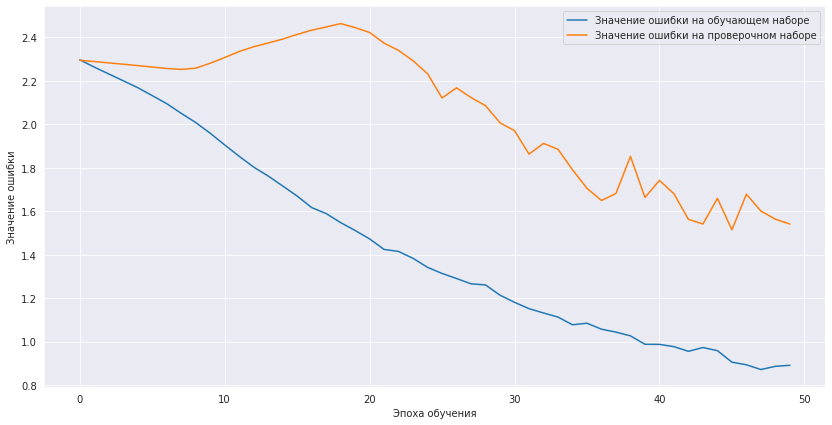

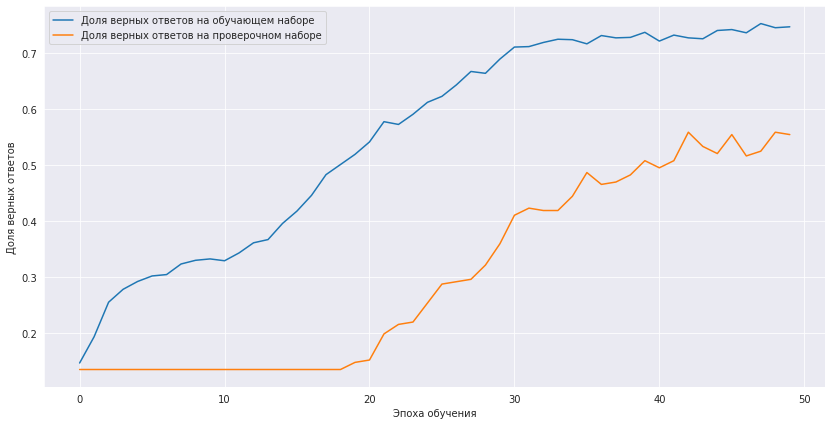

НЕЙРОНКА:  test
--------------------
Процент точности модели: 0.56%


In [ ]:
model = createModel(level=2)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)}%")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 5)             100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 5)             20        
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 20)            520       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 20)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 20)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25, 20)           

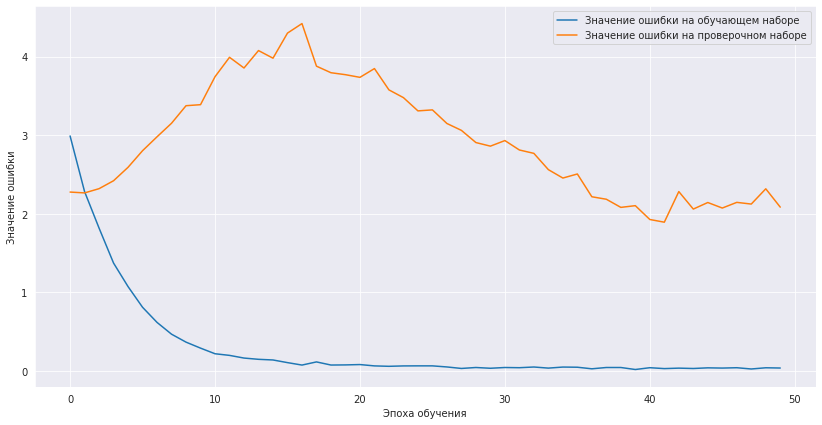

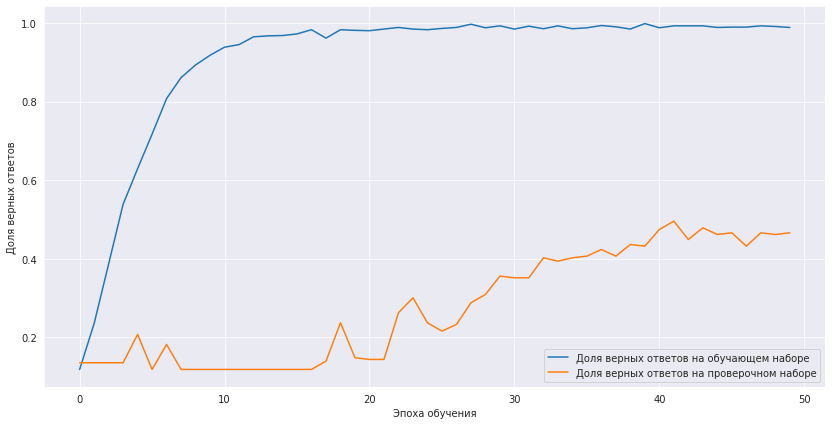

НЕЙРОНКА:  test
--------------------
Процент точности модели: 0.47%


In [ ]:
model = createModel(level=3)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)}%")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 5)             100000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 5)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 5)             20        
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 4)             160       
_________________________________________________________________
dense_4 (Dense)              (None, 50, 100)           500       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 20)            10020     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 20)           

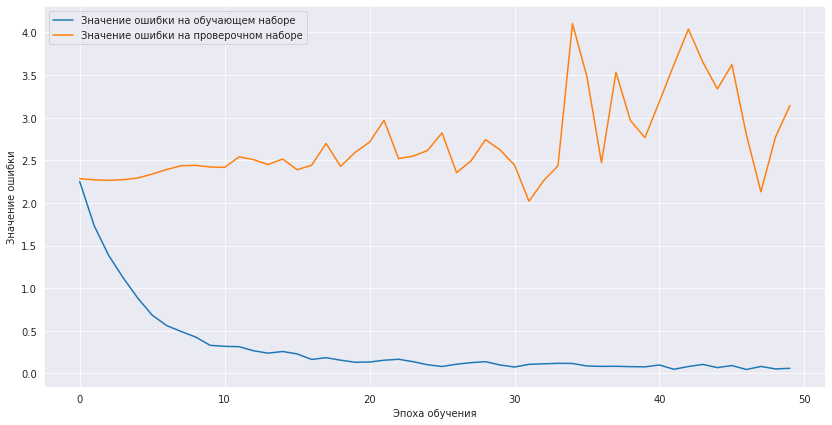

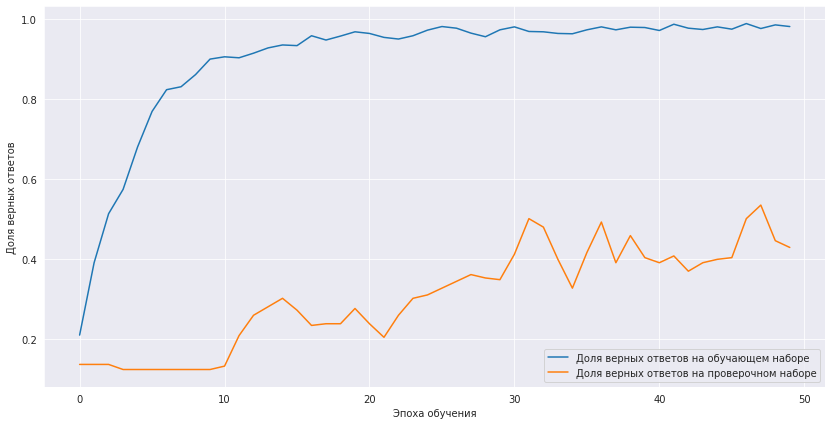

НЕЙРОНКА:  test
--------------------
Процент точности модели: 0.43%


In [ ]:
model = createModel(level=4)

print(plot_model(model, dpi=60, show_shapes=True))
history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)}%")